In [24]:
import pandas as pd

# Load the comparison results CSV
comparison_df = pd.read_csv("comparison_results.csv")

# Display the first few rows to inspect
print(comparison_df.head())

                          id  \
0  bpRNA_CRW_34879|Accession   
1  bpRNA_CRW_47678|Accession   
2  bpRNA_CRW_43733|Accession   
3  bpRNA_CRW_41054|Accession   
4  bpRNA_CRW_18252|Accession   

                                            sequence  \
0                      GGCGGAUGUAGCCAAGUGGAUCAAGGCAG   
1                                 GUCAGGAUAGCUCAGUUG   
2  CGCGGGGUAGAGCAGUUGGUAGCUCGCCGGGCUCAUAACCCGGAGG...   
3  GCGUCAUUAGCUCAGUUGGUAGAGCACACGACUUUUAAUCGUGUUG...   
4                             GGGAAGUCCUCGAUGUUGCACC   

                                  nussinov_structure  \
0                      ..(.....(.(((...(.(())).)))))   
1                                 ..((..(((()).).)))   
2  .((.(((..(.(((...((.(.((((((.(((.(.(...(()))))...   
3  ((((((.((...((((((((.((.(((((((...(()))))))).)...   
4                             (((((...((()).))).).))   

                                     zuker_structure  overlap_score  zuker_mfe  
0                      (((.......)))................

In [25]:
import RNA
RNA.cvar.temperature = 25  # Set to 25°C or another temperature

def stochastic_traceback(sequence, num_samples=100):
    """
    Generate multiple alternative secondary structures using stochastic traceback.
    """
    # Initialize RNA fold compound
    fc = RNA.fold_compound(sequence)
    fc.pf()  # Compute partition function

    # Perform stochastic traceback
    structures = [fc.pbacktrack() for _ in range(num_samples)]
    return structures

# Apply stochastic traceback to all sequences in the DataFrame
def analyze_tracebacks(row, num_samples=10):
    """
    Perform stochastic traceback and compute statistics for a single sequence.
    """
    sequence = row["sequence"]
    structures = stochastic_traceback(sequence, num_samples=num_samples)

    # Compute diversity (unique structures and frequencies)
    unique_structures = set(structures)
    diversity = len(unique_structures)

    # Most common structure
    most_common = max(set(structures), key=structures.count)

    return pd.Series({"traceback_diversity": diversity, "most_common_structure": most_common})

# Add traceback analysis to the DataFrame
comparison_df[["traceback_diversity", "most_common_structure"]] = comparison_df.apply(
    lambda row: analyze_tracebacks(row, num_samples=200), axis=1
)

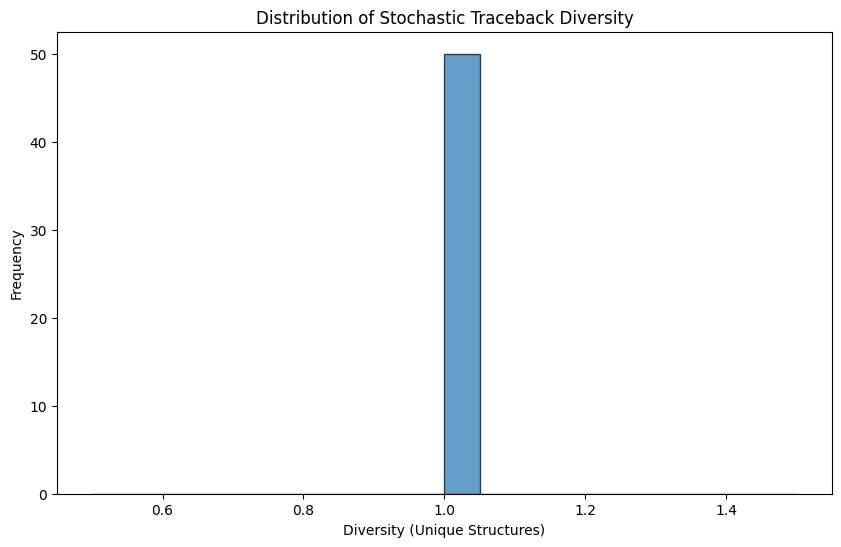

In [26]:
import matplotlib.pyplot as plt

# Histogram of traceback diversity
plt.figure(figsize=(10, 6))
plt.hist(comparison_df["traceback_diversity"], bins=20, alpha=0.7, edgecolor="black")
plt.title("Distribution of Stochastic Traceback Diversity")
plt.xlabel("Diversity (Unique Structures)")
plt.ylabel("Frequency")
plt.show()

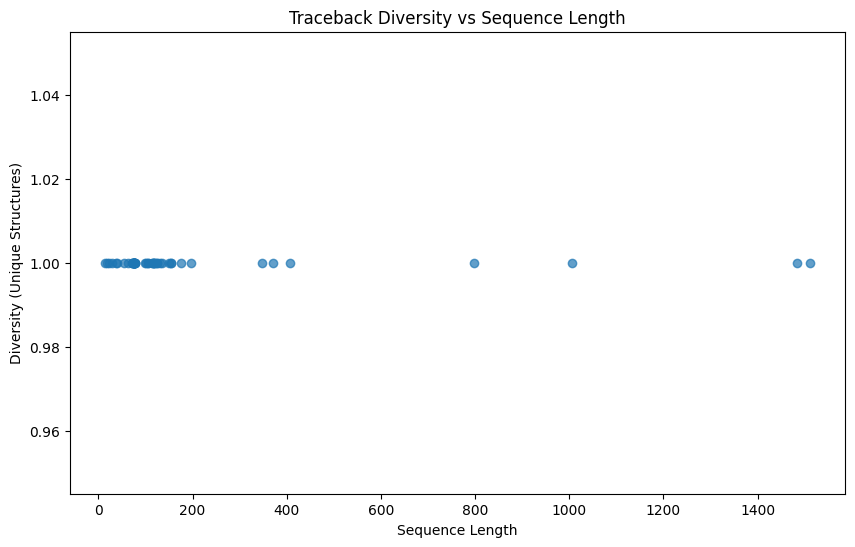

In [27]:
# Scatter plot of sequence length vs traceback diversity
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df["sequence"].str.len(), comparison_df["traceback_diversity"], alpha=0.7)
plt.title("Traceback Diversity vs Sequence Length")
plt.xlabel("Sequence Length")
plt.ylabel("Diversity (Unique Structures)")
plt.show()

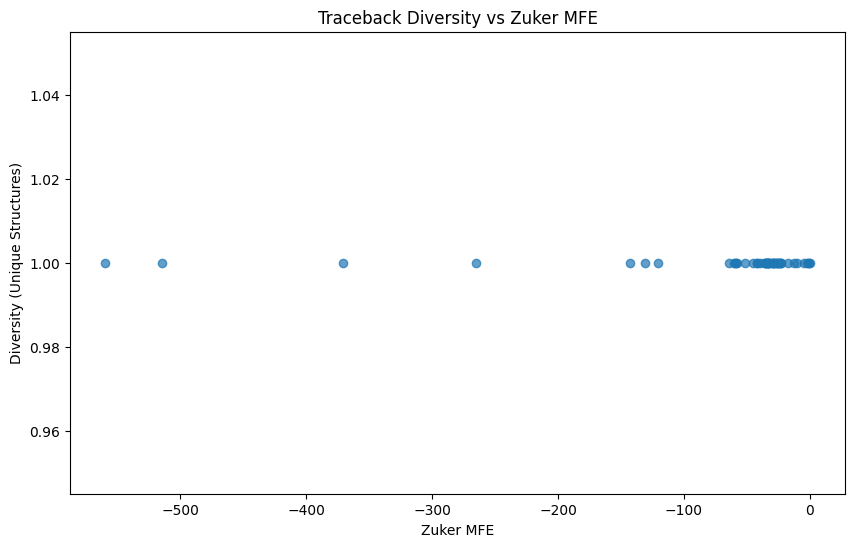

In [28]:
# Scatter plot of MFE vs traceback diversity
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df["zuker_mfe"], comparison_df["traceback_diversity"], alpha=0.7)
plt.title("Traceback Diversity vs Zuker MFE")
plt.xlabel("Zuker MFE")
plt.ylabel("Diversity (Unique Structures)")
plt.show()

In [29]:
comparison_df.to_csv("comparison_with_traceback.csv", index=False)

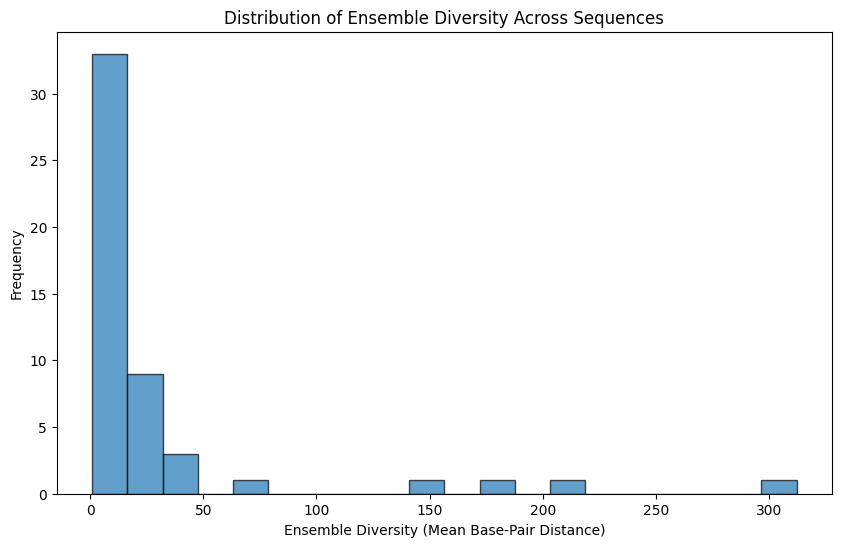

In [30]:
def compute_ensemble_diversity(sequence):
    """
    Computes ensemble diversity for a sequence using ViennaRNA.
    """
    fc = RNA.fold_compound(sequence)
    fc.pf()  # Partition function
    diversity = fc.mean_bp_distance()  # Mean base-pair distance in the ensemble
    return diversity

# Apply to all sequences in the dataset
comparison_df["ensemble_diversity"] = comparison_df["sequence"].apply(compute_ensemble_diversity)

# Visualize the ensemble diversity
plt.figure(figsize=(10, 6))
plt.hist(comparison_df["ensemble_diversity"], bins=20, alpha=0.7, edgecolor="black")
plt.title("Distribution of Ensemble Diversity Across Sequences")
plt.xlabel("Ensemble Diversity (Mean Base-Pair Distance)")
plt.ylabel("Frequency")
plt.show()